In [ ]:
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount("/content/gdrive")

# Change to appropriate directory
%cd "gdrive/MyDrive/EECS 738 Project"

Mounted at /content/gdrive
/content/gdrive/MyDrive/EECS 738 Project


In [ ]:
# ONLY RUN THIS BLOCK ONCE, EVER
# Make .kaggle directory
!mkdir ~/.kaggle/

# Copy kaggle.json into .kaggle directory
!cp kaggle.json ~/.kaggle/

# Grant appropriate permissions
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# ONLY RUN THIS BLOCK ONCE, EVER
# Unzip dataset (Warning: Takes a long time, ~35 min, 202600 images)
!unzip celeba-dataset.zip

Archive:  celeba-dataset.zip
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# BEGIN CODE CHRIS IS FIDDLING WITH

In [ ]:
import os
import PIL
import matplotlib.pyplot as plt

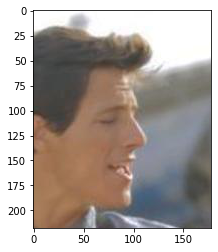

In [ ]:
with PIL.Image.open("img_align_celeba/img_align_celeba/000003.jpg") as img:
    plt.imshow(img)

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import f1_score

import os

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
# from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
from scipy import misc

plt.style.use("ggplot")
%matplotlib inline

In [ ]:
images_folder = "img_align_celeba/img_align_celeba/"

example_pic = images_folder + "000506.jpg"

training_sample = 10000
validation_sample = 2000
test_sample = 2000
img_width = 178
img_height = 218
batch_size = 64
num_epochs = 30

In [ ]:
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True)

In [ ]:
df_attr.head(5)

In [ ]:
df_attr.describe()

In [ ]:
df_attr.columns

In [ ]:
df_attr.isnull().sum()

In [ ]:
df_attr.shape

In [ ]:
for i,j in enumerate(df_attr.columns):
    print(i+1, j)

In [ ]:
# load a example image

img = load_img(example_pic)
plt.grid(False)
plt.imshow(img)
df_attr.loc[example_pic.split('/')[-1]][['Smiling','Male',"Young"]]

In [ ]:
sns.countplot(df_attr["Male"])
plt.show()

In [ ]:
df_partition = pd.read_csv("list_eval_partition.csv")
df_partition.head(5) # Viewing the first 5 lines

In [ ]:
df_partition.sample(100) # Extract 100 random elements 

In [ ]:
df_partition["partition"].value_counts().sort_index()

In [ ]:
df_partition.set_index('image_id', inplace=True) # Set the DataFrame index using columns 'image_id'.
df_par_attr = df_partition.join(df_attr["Male"], how="inner") # Join DataFrames using same indexes

df_par_attr.head(10) 

In [ ]:
df_par_attr.shape

In [ ]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,)+x.shape)
    return x

In [ ]:
def generate_df(partition, attr, num_samples):
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
        
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (img_width, img_height)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [ ]:
# generate image generator for data augmentation

datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# load one image and reshape

img = load_img(example_pic)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded image

plt.figure(figsize=(20,10))
plt.suptitle("Data augmentation", fontsize=28)

i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3,5,i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218,178, 3))
    
    if i==9:
        break
    i = i+1
    
plt.show()

In [ ]:
# build data generators

# train data

x_train, y_train = generate_df(0, "Male", training_sample)

# Modify the training data
# ====================================
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

In [ ]:
# validation data

x_valid, y_valid = generate_df(1, "Male", validation_sample)

In [ ]:
print(y_train.shape)

In [ ]:
batch_size = 64
num_epochs = 30

In [ ]:
train_datagen.fit(x_train)

model = Sequential()
# Add two convolutional layers with 32 7x7 kernels
# --------------------------------------------------
model.add(Conv2D(32, (7, 7), activation='relu', input_shape=(218, 178, 3)))
model.add(BatchNormalization())
#model.add(Conv2D(32, (7, 7), activation='relu'))
#model.add(Conv2D(32, (7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(BatchNormalization()) # Don't forget this, it's really important

# Go deeper by adding two layers with 64, 5x5 kernels
model.add(Conv2D(64, (5, 5), activation='relu'))
#model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Go deeper by adding 1 layer with 128, 3x3 kernels
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
#weight = ModelCheckpoint(weight1, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', verbose=1, save_best_only=True)
# Load the pre-trained weights and train, then save new weights
# -------------------------------------------------------------
#model.load_weights(weight1, by_name=False)
hist = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=64), steps_per_epoch=len(x_train)/batch_size, epochs=num_epochs,validation_data=(x_valid, y_valid),callbacks=[checkpointer],verbose=1)
#hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_valid, y_valid),callbacks=[weight])
#model.save_weights(weight1)
#score = model.evaluate(x_test, y_test, batch_size=batch_size)

In [ ]:
# plot loss with epochs

plt.figure(figsize=(18,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.title('loss function')
plt.show()

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
# load the best model

model_.load_weights('weights.best.inc.male.hdf5')

In [ ]:
# test data

x_test, y_test = generate_df(2, 'Male', test_sample)

# generate predictions

model_prediction = [np.argmax(model_.predict(feature)) for feature in x_test]

# report test accuracy

test_accuracy = 100 * (np.sum(np.array(model_prediction)==y_test)/len(model_prediction))
print('model evaluation')
print("test accuracy : ", test_accuracy)
print('f1 score : ', f1_score(y_test, model_prediction))